In [2]:
# import and all, don't touch this
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
from sklearn.datasets import *
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.svm import SVC
from sklearn.semi_supervised.label_propagation import LabelPropagation
from mlxtend.plotting import plot_decision_regions

from algo import algo
from utils import plot, plot_interesting_points, square, disk, square_without_disk, denoise, compare

plt.rcParams['figure.figsize'] = [6, 6]
mpl.rcParams['figure.dpi']= 250

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_gamma():
    somme = 0
    pairs = len(best)//2

    for i in range(0, pairs+1, 2):
        somme += pairwise_distances(X_cleaned[best[i]].reshape(1, 2), X_cleaned[best[i+1]].reshape(1, 2))

    d = somme/pairs
    print("GAMMA should be: ", 9/(d**2))
    return(9/(d**2)[0][0])

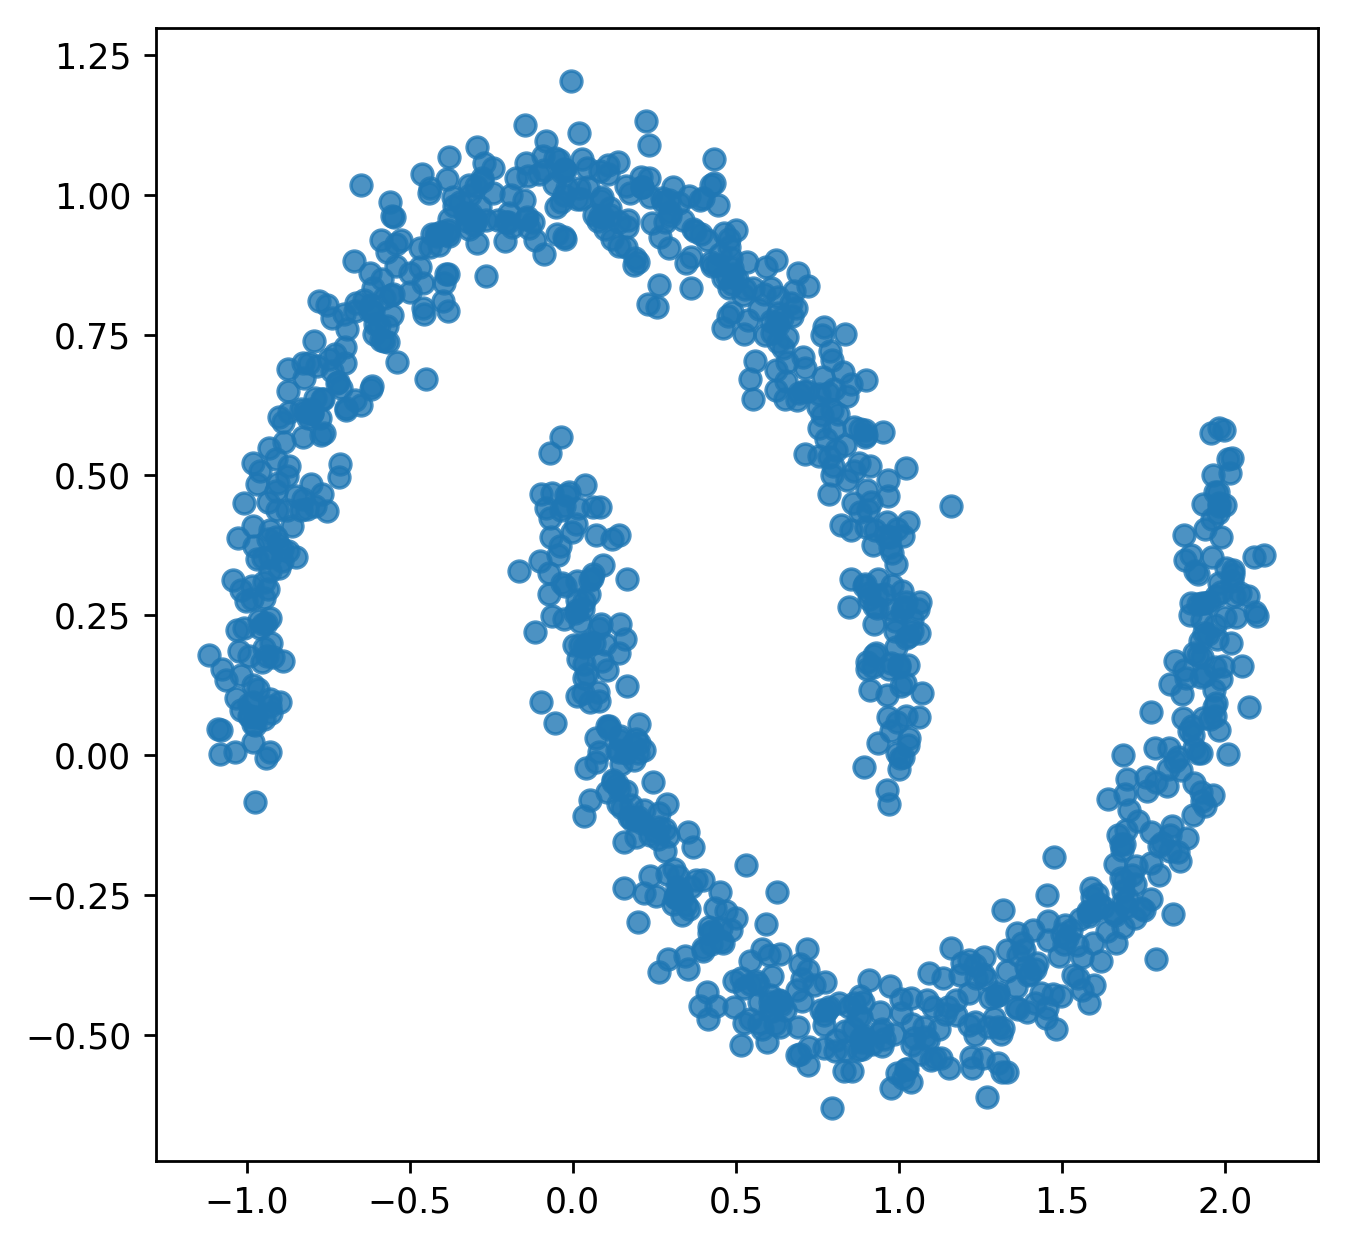

In [4]:
x = np.linspace(-2, 2, 500)
noise = np.random.normal(0.1,0.1,len(x))
x2 = x**2 + noise + 2
x2 = np.array([[i, j] for (i,j) in zip(x, x2)])

"""
x = np.linspace(0.1, 5, 500)
noise = np.random.normal(0.1,0.1,len(x))
log = np.log(x) + noise + 7
x -= 2
log = np.array([[i, j] for (i,j) in zip(x, log)])+1
"""

X = np.concatenate((x2, disk(400, (0, 4))))
Y = np.zeros(X.shape[0])
Y[500:900] = 1

# density diff
_ = """moons, ym =  make_moons(1000, noise=0.15)
moons -= 0
moons *= 2
blobs, yb =  make_blobs(100, random_state=14)
ym[:] = 0

X = np.concatenate((moons, blobs+2)) # +2 to move blobs
Y = np.concatenate((ym, yb+1)) # +1 to get different classes for blobs and moon
"""

# disk and rond pas centré
_ = """
X = np.concatenate(
    (square_without_disk(1000, size=1.2, r_circle=1.1), disk(n=300, center=(0, 0.35), r=0.5))
)
Y = np.ones(X.shape[0])
Y[-300:] = 0
"""
X, Y = make_moons(1000, noise=0.06)
# X, Y = make_blobs(1000)


idx_del = denoise(pairwise_distances(X, metric='euclidean'), k=4, eps=np.inf)
X_cleaned = X[[i for i in range(X.shape[0]) if i not in idx_del]]
Y_cleaned = Y[[i for i in range(Y.shape[0]) if i not in idx_del]]

plot_interesting_points(X, idx_del, alpha=0.15)

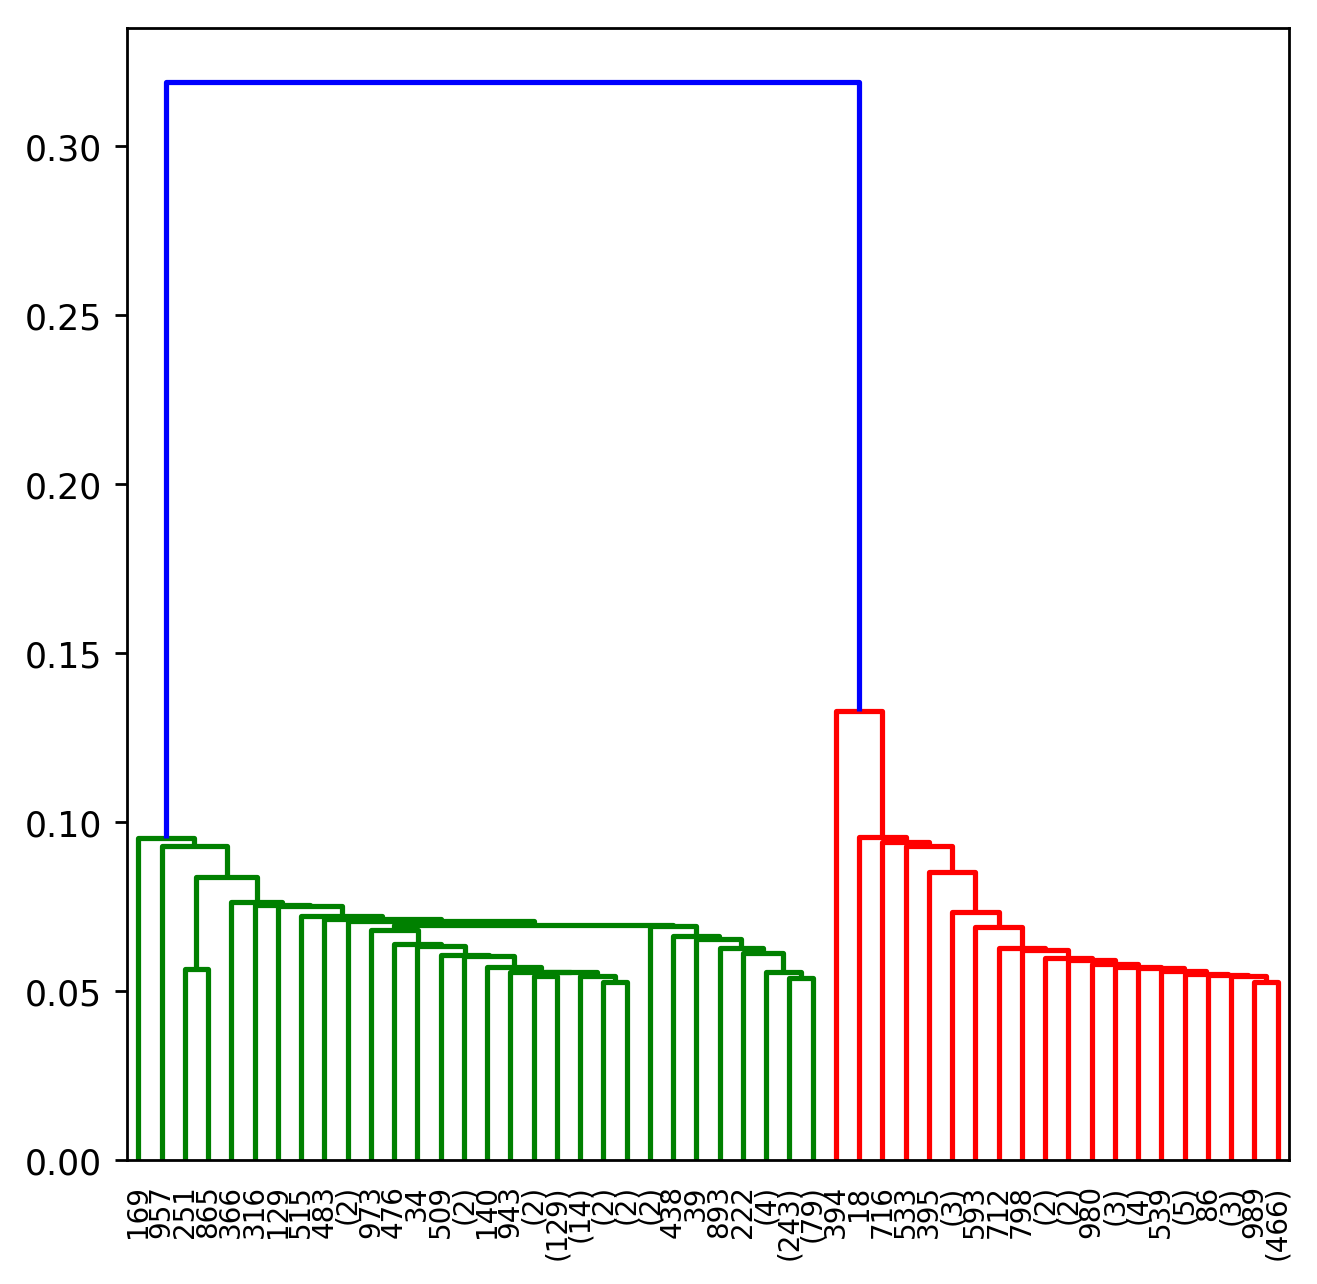

In [5]:
dist = squareform(pairwise_distances(X_cleaned, X_cleaned, 'euclidean'), checks=False)
link = linkage(dist, "single")
dend = dendrogram(link, truncate_mode="lastp", p=50)

### Our algo

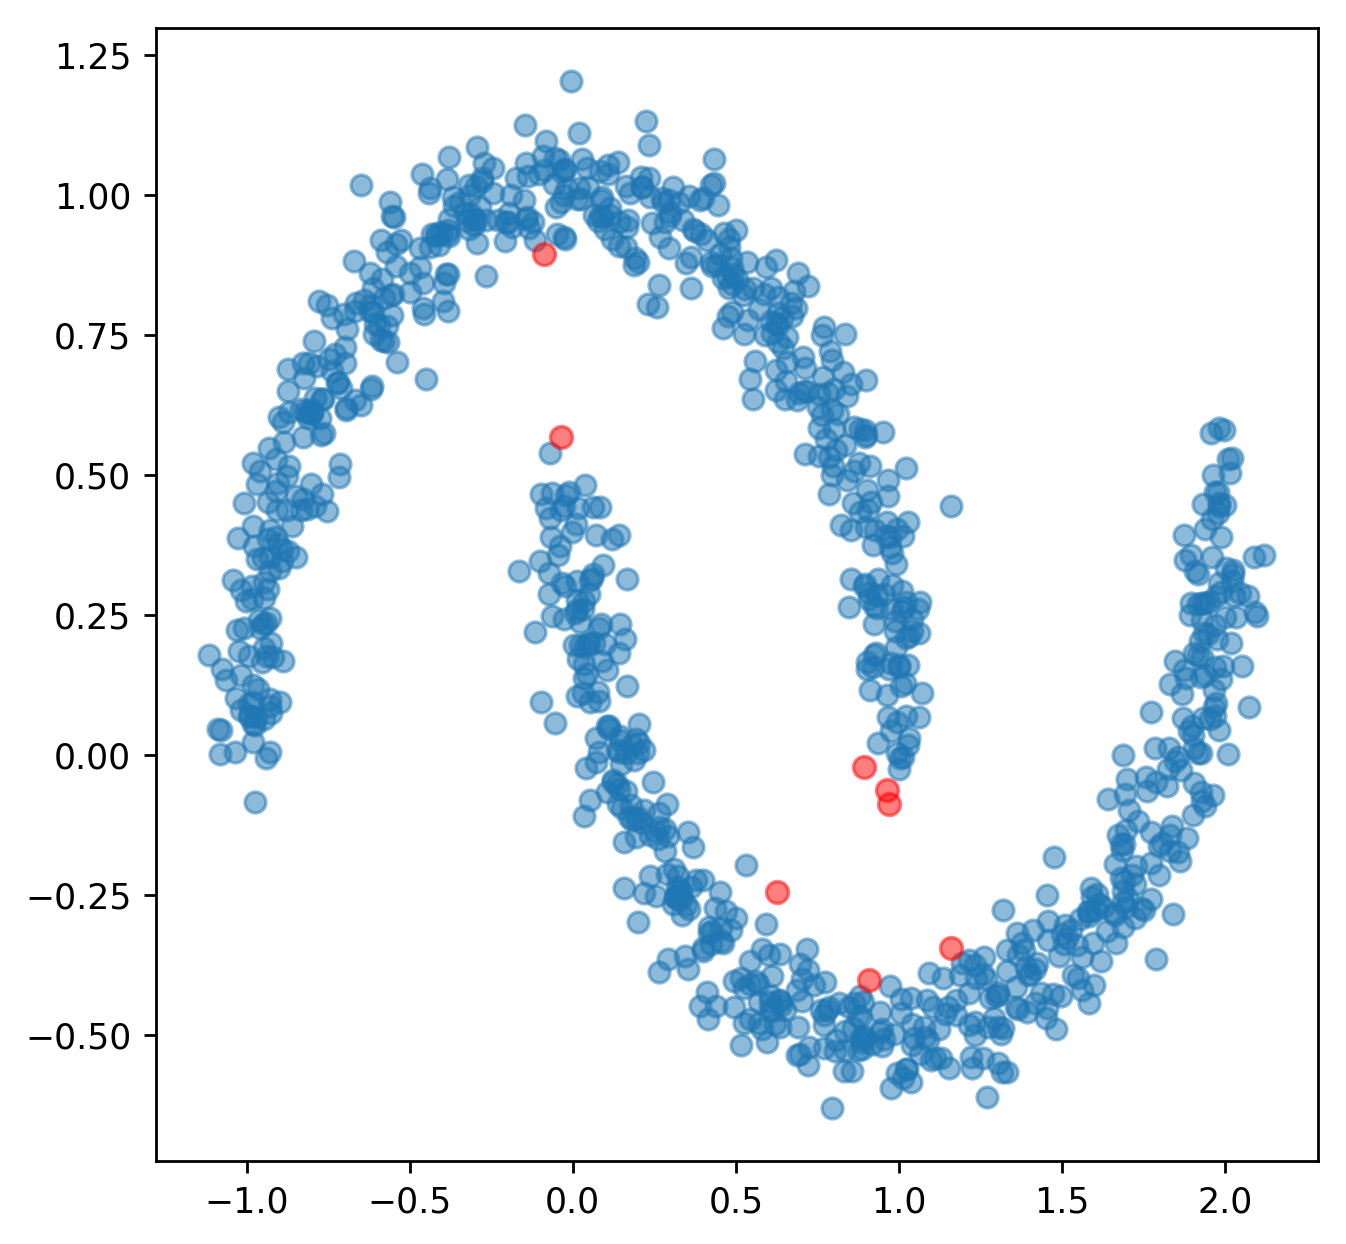

In [6]:
n = 4
s = 4
best = algo(X_cleaned, n=n, s=s, min_size=4, metric='euclidean')
plot_interesting_points(X_cleaned, best, alpha=0.5, alpha_main=0.5)

### Left side: random points, right side: our algo

CPU times: user 14.1 s, sys: 396 ms, total: 14.5 s
Wall time: 14.1 s


(5672, 3246)

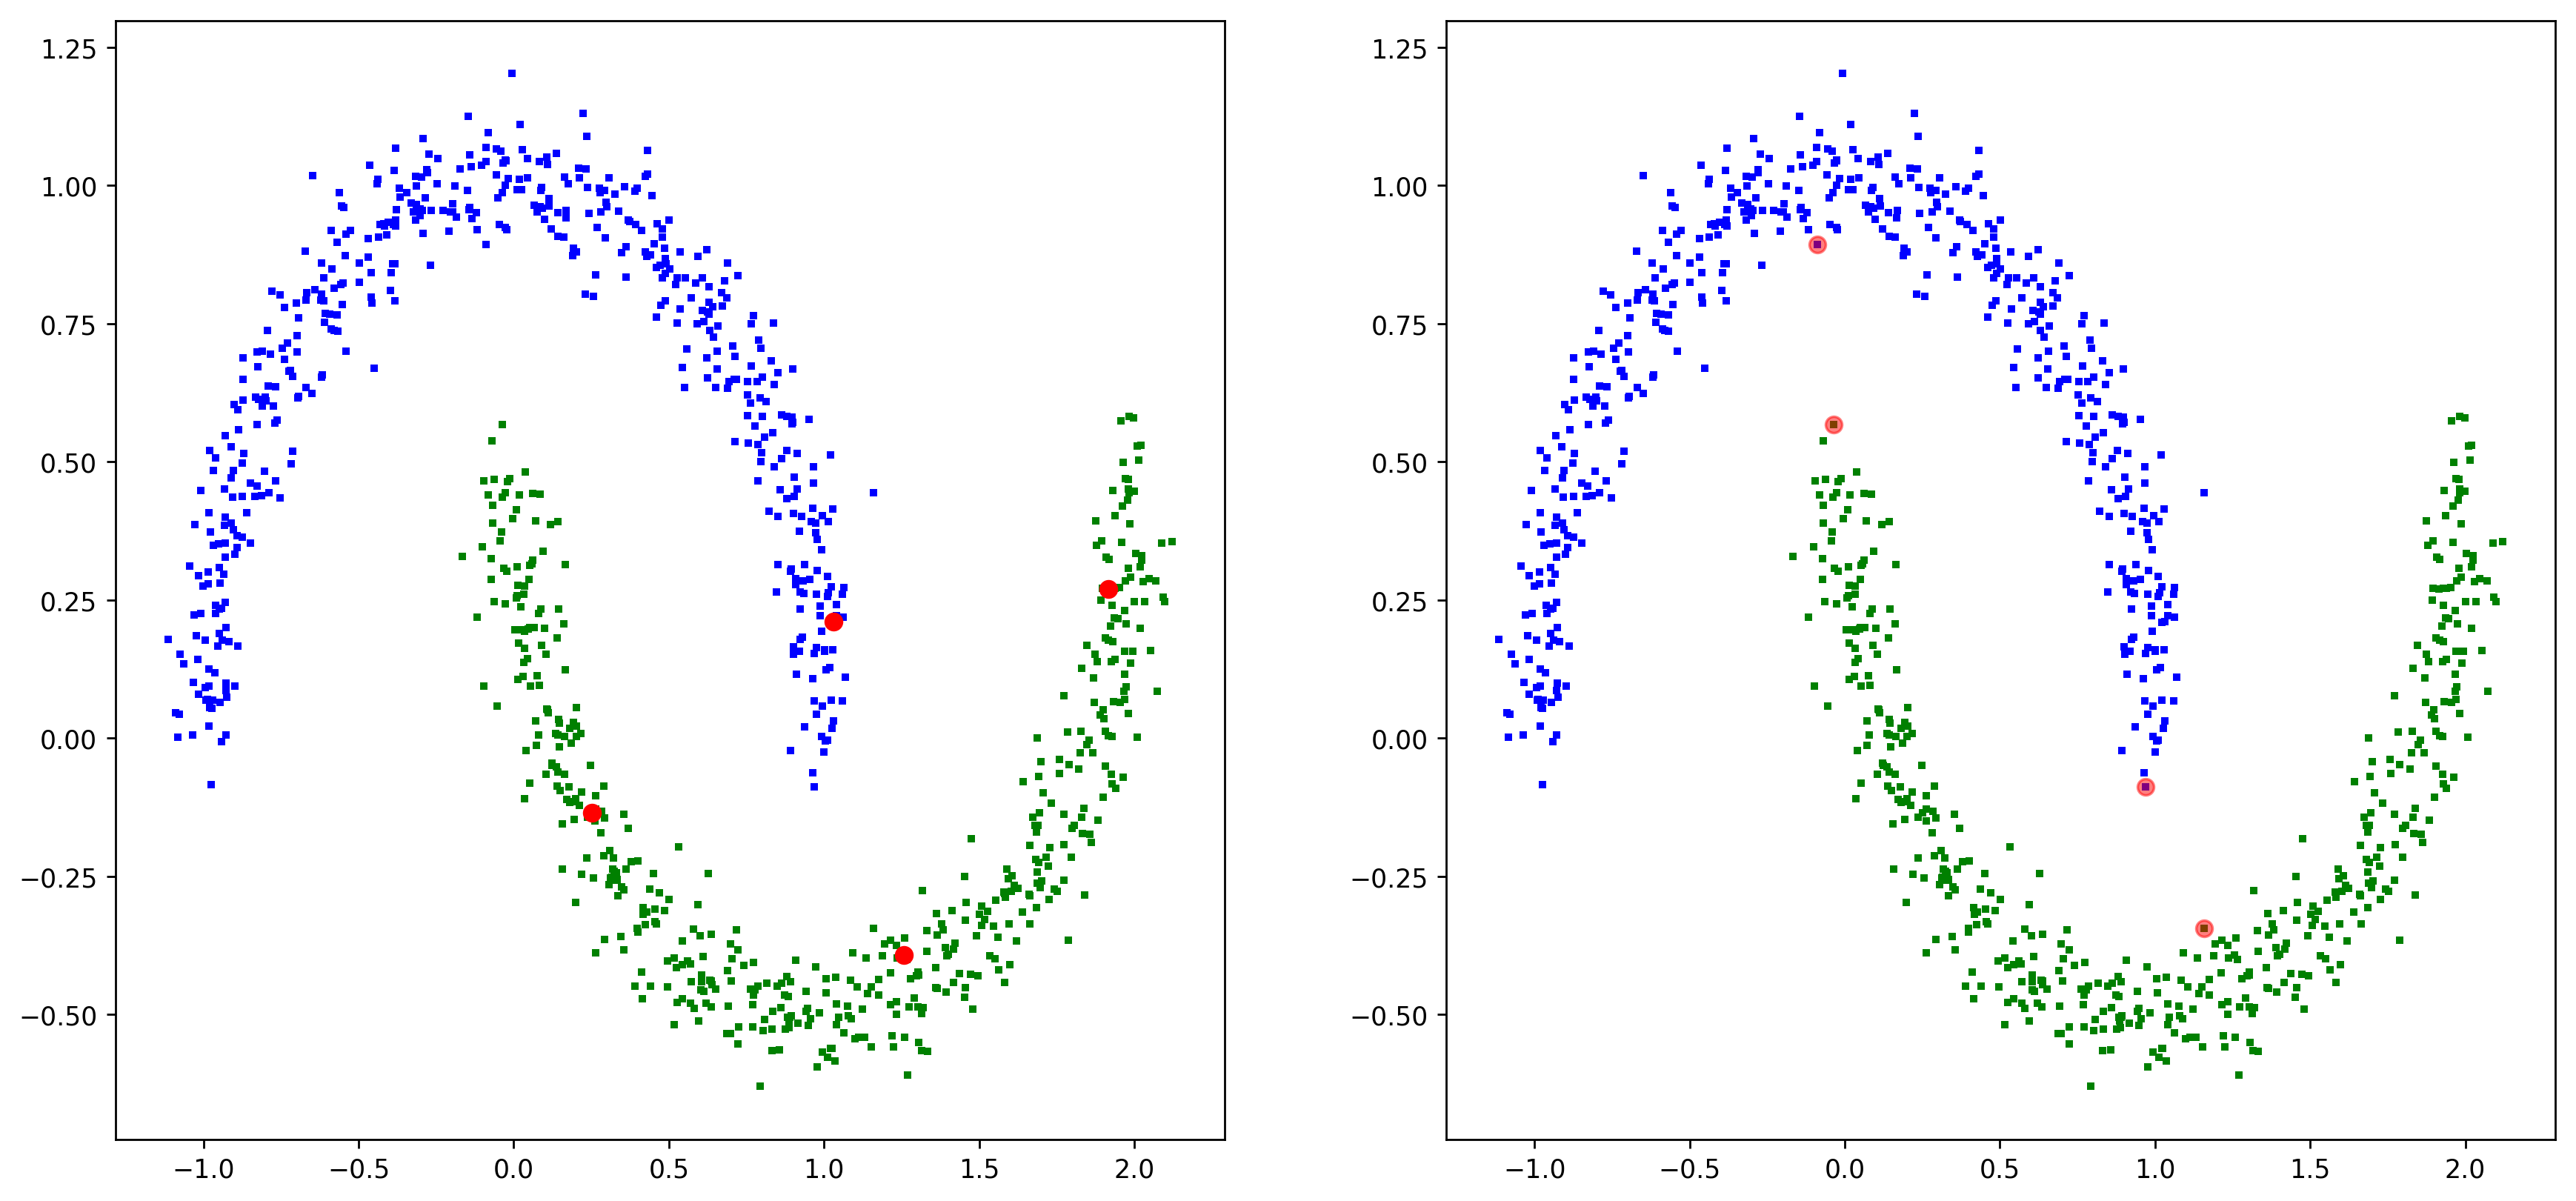

In [7]:
%time compare(X_cleaned, Y_cleaned, 4, best, tol=0.01, max_iter=10000, gamma=80, kernel='rbf')

The "Out" is the number of iterations before convergence

#### SVM with just 8 points

0.743

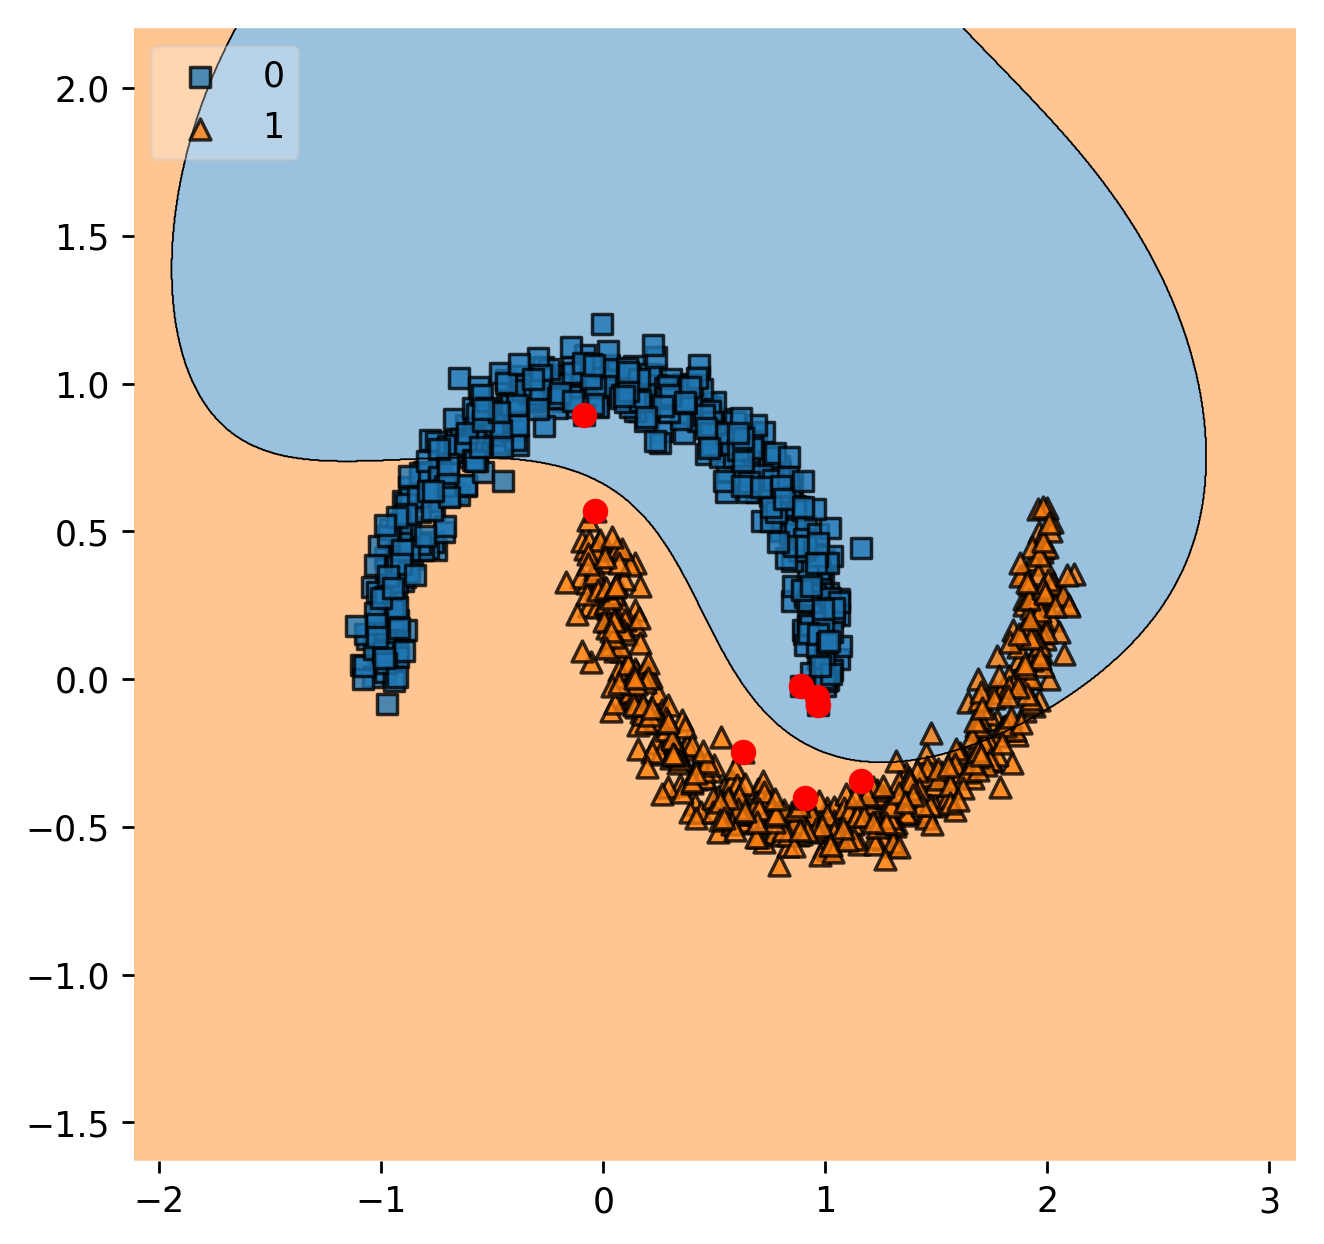

In [8]:
svm = SVC(kernel='rbf', gamma='scale', degree=3, C=10, class_weight='balanced')
clf = svm

clf.fit(X_cleaned[best], Y_cleaned[best])

plot_decision_regions(X, Y.astype(np.integer), clf=clf, legend=2)
plot_interesting_points(X_cleaned, best, 1, 0)

clf.score(X, Y)

#### SVM after LabelPropagation

1191


1.0

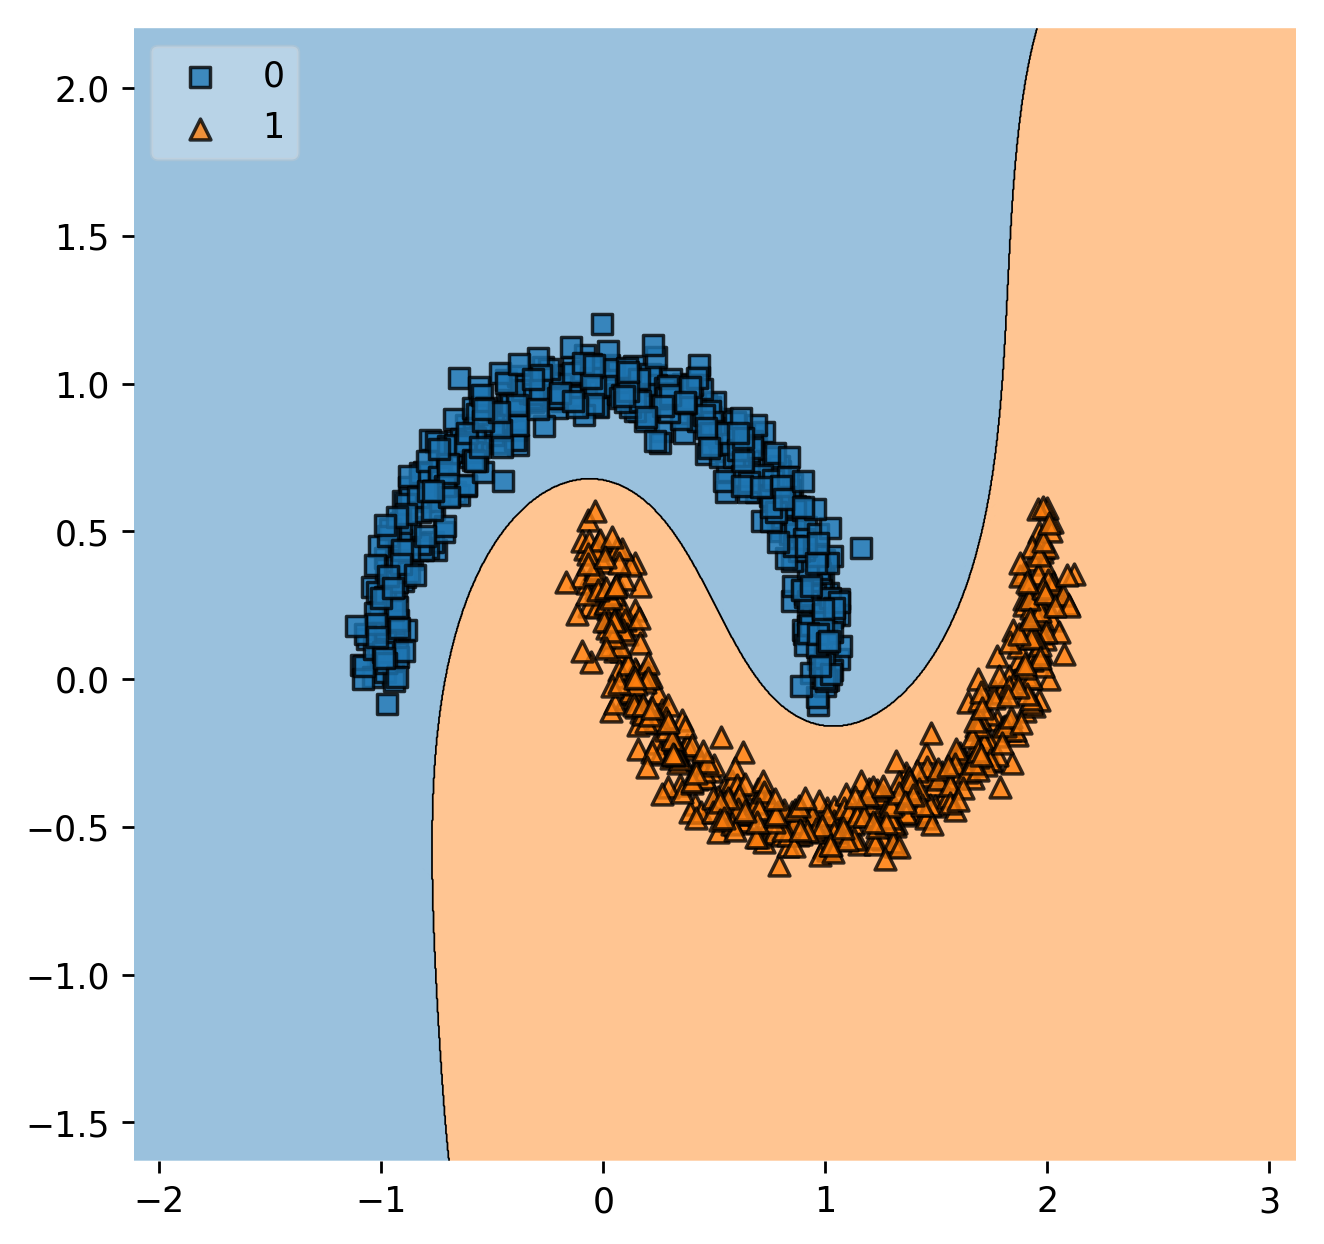

In [9]:
Y_unlab = -np.ones(X_cleaned.shape[0])
Y_unlab[best] = Y[best]
label_spread = LabelPropagation(kernel='rbf', tol=0.01, max_iter=5000)
label_spread.fit(X_cleaned, Y_unlab)
Y_predict = label_spread.transduction_
print(label_spread.n_iter_)

svm = SVC(kernel='rbf', gamma='scale', degree=3, C=1, class_weight='balanced')
clf = svm

clf.fit(X_cleaned, Y_predict)

plot_decision_regions(X, Y.astype(np.integer), clf=clf, legend=2)

clf.score(X, Y)
